<a href="https://colab.research.google.com/github/SaeidDaliriSusefi/FloodMapping-JRC/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import numpy as np
import matplotlib.patches as patches
import matplotlib.colors as mcolors

In [2]:
ee.Authenticate()
ee.Initialize(project="ee-saeiddalirisu", opt_url='https://earthengine-highvolume.googleapis.com')

In [3]:
# Define ROI (Italy)
country_name = 'Italy'
country = (ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
    .filter(ee.Filter.eq('country_na', country_name)))
roi = country.geometry()

In [4]:
# Select the area of intrest
#map=geemap.Map(basemap="SATELLITE")
#map


In [5]:
#roi = map.draw_last_feature.geometry()

<ipython-input-6-e55b78d0adc7>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


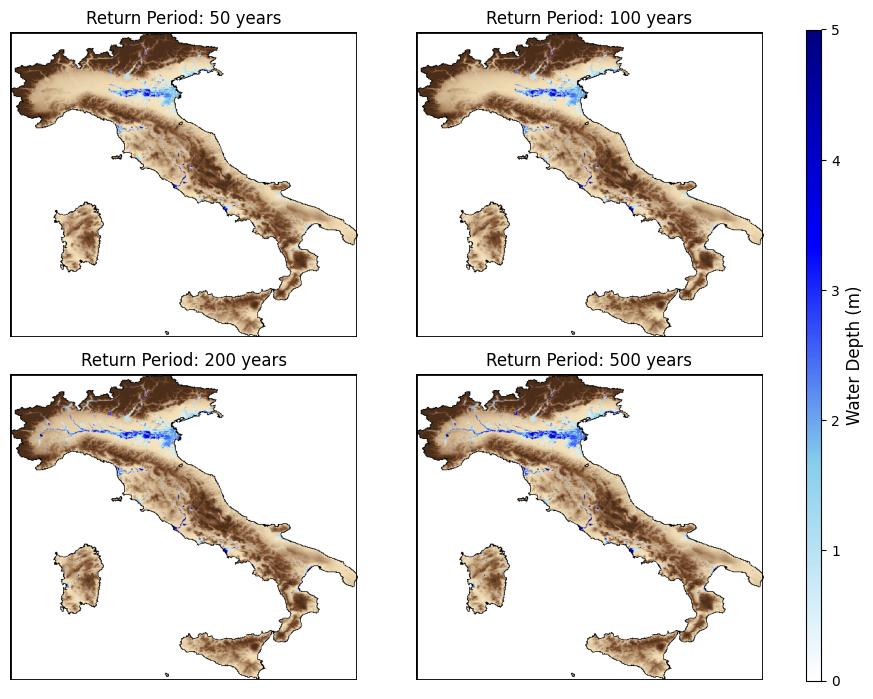

In [6]:
# Load JRC GLOFAS Flood Hazard dataset
jrc = ee.ImageCollection("JRC/CEMS_GLOFAS/FloodHazard/v1")

# Load and exaggerate SRTM Terrain (2x exaggeration)
exaggeration_factor = 4
srtm = ee.Image('USGS/SRTMGL1_003').clip(roi)
srtm_exaggerated = srtm.multiply(exaggeration_factor)
terrain_vis = srtm_exaggerated.visualize(min=0, max=6000, palette=['#f7e4bc','#805333', '#4b2e1a'])

# Create painted Italy border
italy_outline = ee.Image().byte().paint(featureCollection=country, color=0, width=1)
boundary_vis = italy_outline.visualize(palette=['black'])

# Define return periods
return_periods = [50, 100, 200, 500]

# Visualization parameters for flood depth (in meters)
vmin, vmax = 0, 5
palette = ['white', 'skyblue', 'blue', 'navy']

# Create 2x2 plot layout
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
axs = axs.flatten()

# Generate plots
for i, rp in enumerate(return_periods):
    flood = jrc.filter(ee.Filter.eq('return_period', rp)).mosaic().clip(roi)
    flood_vis = flood.visualize(min=vmin, max=vmax, palette=palette)

    # Blend exaggerated terrain base, flood depth, and boundary
    composite = terrain_vis.blend(flood_vis).blend(boundary_vis)

    # Get thumbnail URL
    thumbnail = composite.getThumbURL({
        'region': roi,
        'dimensions': 512
    })

    # Display thumbnail image
    img = np.array(Image.open(urllib.request.urlopen(thumbnail)))
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f'Return Period: {rp} years')

    # Add rectangle frame inside each subplot
    rect = patches.Rectangle(
        (0, 0), 1, 1, transform=axs[i].transAxes,
        linewidth=2, edgecolor='black', facecolor='none'
    )
    axs[i].add_patch(rect)

    # Add red borders to confirm equal sizes
    for spine in axs[i].spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(1)

# Add shared vertical colorbar
cmap = mcolors.LinearSegmentedColormap.from_list('custom_palette', palette)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cbar_ax = fig.add_axes([0.87, 0.02, 0.015, 0.93])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cbar_ax, orientation='vertical')
cbar.set_label('Water Depth (m)', fontsize=12)

# Final layout
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()
